In [1]:
import tifffile as tiff
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate


In [2]:
import tensorflow as tf


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0Metal device set to: Apple M2 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB




2023-11-23 14:48:07.986383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 14:48:07.986656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

169001437/169001437 [==============================] - 6s 0us/step


2023-11-23 14:49:36.251342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-23 14:49:36.251376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2023-11-23 14:49:37.832230: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-23 14:49:39.665338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


775/782 [============================>.] - ETA: 0s - loss: 4.8061 - accuracy: 0.0661

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [6]:
IMG_HEIGHT = 768
IMG_WIDTH = 1024
IMG_CHANNELS = 1



In [7]:
# Open the image file
x_train= tiff.imread('/content/drive/MyDrive/intenship/training.tif')
y_train = tiff.imread('/content/drive/MyDrive/intenship/training_groundtruth.tif')

In [7]:
print(x_train.shape)

(165, 768, 1024)


In [8]:
x_train= np.expand_dims(x_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)

In [13]:
y_train.shape

(165, 768, 1024, 1)

In [14]:
x_train.shape

(165, 768, 1024, 1)

In [15]:
x_train[1]

array([[[124],
        [127],
        [131],
        ...,
        [173],
        [174],
        [176]],

       [[101],
        [118],
        [115],
        ...,
        [187],
        [195],
        [187]],

       [[108],
        [105],
        [111],
        ...,
        [190],
        [181],
        [190]],

       ...,

       [[113],
        [133],
        [126],
        ...,
        [163],
        [148],
        [162]],

       [[122],
        [127],
        [136],
        ...,
        [126],
        [158],
        [170]],

       [[144],
        [135],
        [118],
        ...,
        [137],
        [149],
        [162]]], dtype=uint8)

In [23]:
x_train = x_train.astype('float32') / 255.0
y_train = y_train.astype('float32') / 255.0  # Only do this if your masks are in the same format as your images


In [15]:
!pip install keras

In [13]:
def iou(y_true, y_pred, smooth=1):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true,[1,2,3])+tf.keras.backend.sum(y_pred,[1,2,3])-intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou


In [14]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [9]:
from keras.models import Model, load_model

from keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [15]:

#Build the model
inputs = tf.keras.layers.Input((768, 1024, 1))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
modelu = tf.keras.Model(inputs=[inputs], outputs=[outputs])
modelu.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coefficient, iou])
modelu.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 768, 1024, 1)]       0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 768, 1024, 1)         0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 768, 1024, 16)        160       ['lambda_1[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 768, 1024, 16)        0         ['conv2d_19[0][0]']           
                                                                                            

In [27]:
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss'),
           tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [58]:
results=modelu.fit(x_train,y_train,validation_split=0.1,batch_size=4,epochs=25,callbacks=callbacks)

Epoch 1/25
37/37 [==============================] - 32s 625ms/step - loss: 0.2222 - accuracy: 0.9420 - dice_coefficient: 0.0637 - iou: 0.0320 - val_loss: 0.2039 - val_accuracy: 0.9583 - val_dice_coefficient: 0.0639 - val_iou: 0.0330
Epoch 2/25
37/37 [==============================] - 22s 588ms/step - loss: 0.2181 - accuracy: 0.9420 - dice_coefficient: 0.0720 - iou: 0.0366 - val_loss: 0.2061 - val_accuracy: 0.9583 - val_dice_coefficient: 0.0640 - val_iou: 0.0330
Epoch 3/25
37/37 [==============================] - 22s 583ms/step - loss: 0.2189 - accuracy: 0.9420 - dice_coefficient: 0.0668 - iou: 0.0338 - val_loss: 0.1921 - val_accuracy: 0.9583 - val_dice_coefficient: 0.0702 - val_iou: 0.0364
Epoch 4/25
37/37 [==============================] - 21s 575ms/step - loss: 0.1954 - accuracy: 0.9420 - dice_coefficient: 0.1057 - iou: 0.0555 - val_loss: 0.1483 - val_accuracy: 0.9583 - val_dice_coefficient: 0.1695 - val_iou: 0.0926
Epoch 5/25
37/37 [==============================] - 21s 574ms/step -

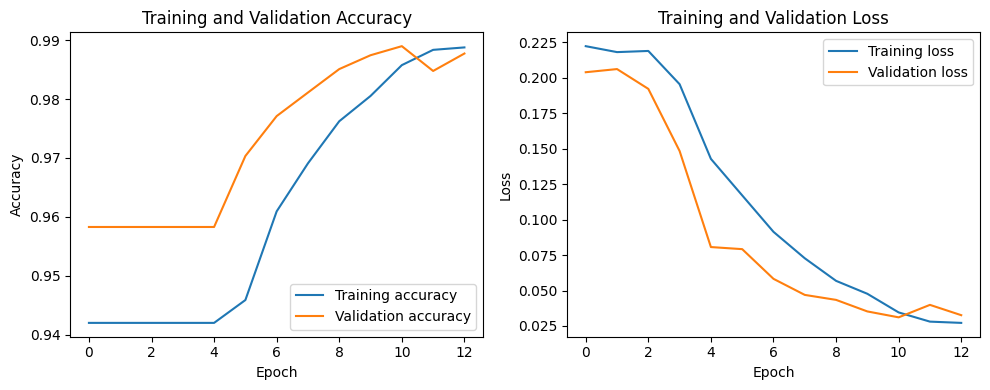

In [70]:
import matplotlib.pyplot as plt

# Assuming 'history' is the output from the fit function
# history = model.fit(x_train, y_train, validation_split=0.1, batch_size=10, epochs=50, callbacks=callbacks)

# Replace 'history.history['accuracy']' and 'history.history['val_accuracy']' with your actual data
# Replace 'history.history['loss']' and 'history.history['val_loss']' with your actual data

# Plot training & validation accuracy values
history = results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [27]:

x_test = tiff.imread('/content/drive/MyDrive/intenship/testing.tif')


In [28]:
x_test = np.expand_dims(x_test, axis=-1)

In [29]:
x_test = x_test.astype('float32') / 255.0

In [30]:
predict_test=modelu.predict(x_test,verbose=1)

6/6 [==============================] - 5s 720ms/step


In [63]:
print(predict_test[0].max())  # Should be greater than the threshold if there are positive predictions


0.9999933


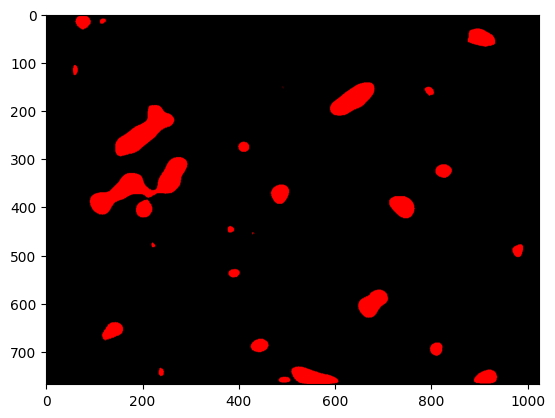

In [32]:
# Assuming predict_test is your model output and x_test is the normalized test image
thresholded_mask = (predict_test[0] > 0.9).astype(np.uint8)  # Apply threshold

# Remove the extra channel dimension from thresholded_mask if necessary
thresholded_mask_squeezed = np.squeeze(thresholded_mask)

# Create an RGB version of the grayscale image for visualization
x_test_rgb = np.stack((x_test[0, ..., 0],) * 3, axis=-1)

# Overlay the mask on the image
# The mask is used as a condition, and where it's true, we'll show the mask
# Where it's false, we'll show the original image
overlay = np.where(thresholded_mask_squeezed[..., None],  # Add an axis to match x_test_rgb's last dimension
                   np.array([255, 0, 0]),  # Red color for the mask
                   x_test_rgb)  # Original image where the condition is false

# Since overlay will be a float, we may need to convert it to uint8 to display it correctly with plt.imshow
overlay = overlay.astype(np.uint8)

plt.imshow(overlay)
plt.show()


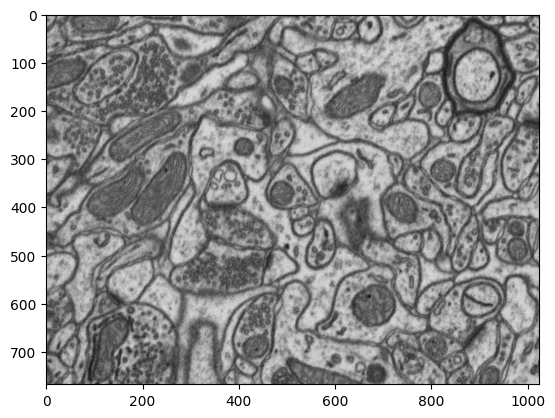

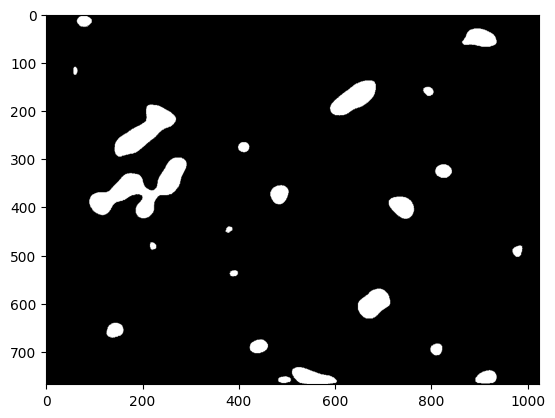

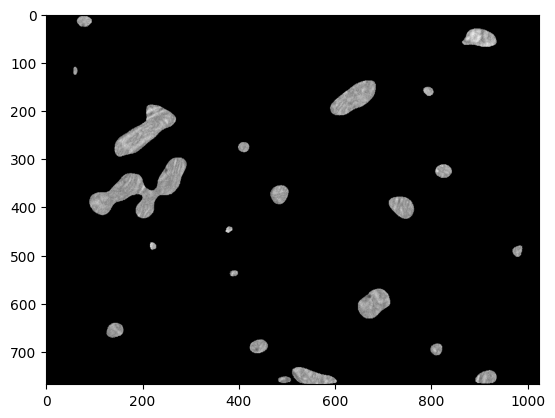

In [33]:
# Assuming predict_test is your model output and x_test is the normalized test image
thresholded_mask = (predict_test > 0.9).astype(np.uint8)

# Display original image
plt.imshow(x_test[1], cmap='gray')
plt.show()

# Display predicted mask
plt.imshow(thresholded_mask[1], cmap='gray')
plt.show()

# Overlay the mask on the image
overlay = np.where(thresholded_mask[1], x_test[1], 0)  # This will show the mask in place of the original image
plt.imshow(overlay, cmap='gray')
plt.show()


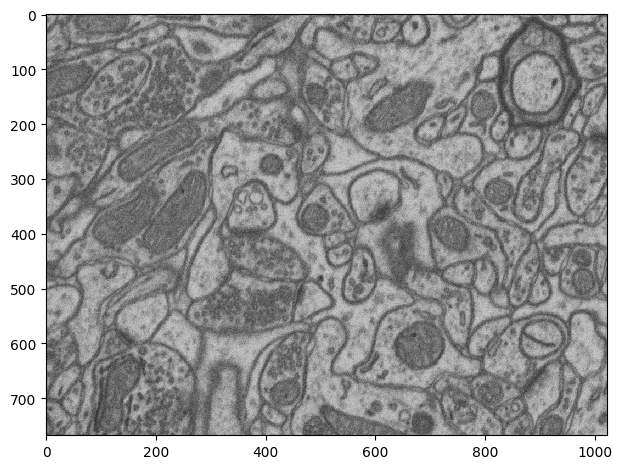

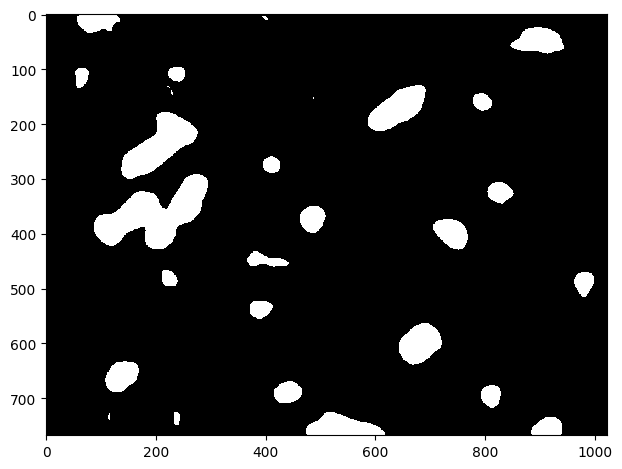

In [67]:
imshow(x_test[1])
plt.show()
imshow(np.mean(thresholded_mask[1], axis=2))
plt.show()

In [8]:
x_test =tiff.imread('/content/drive/MyDrive/intenship/testing.tif')
y_test = tiff.imread('/content/drive/MyDrive/intenship/testing_groundtruth.tif')

In [75]:
# modelu.save('/content/drive/MyDrive/intenship/my_saved_model.h5')  # This will save the model in HDF5 format


In [18]:
from tensorflow.keras.models import load_model
modelu = load_model('/content/drive/MyDrive/intenship/my_saved_model.h5', custom_objects={'dice_coefficient': dice_coefficient,'iou':iou})

In [19]:
def preprocss_data(df):
  df = df.astype('float32') / 255.0
  return df


In [20]:
y_test = preprocss_data(y_test)
x_test = preprocss_data(x_test)

In [21]:
predictions = modelu.predict(x_test)


6/6 [==============================] - 34s 1s/step


In [ ]:
modelu = load_model('/content/drive/MyDrive/intenship/my_saved_model.h5')

In [22]:
predictions_thresholded = (predictions > 0.5).astype(np.uint8)


In [23]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Flatten the predictions and labels to compute the metrics
y_true_flat = y_test.flatten()
y_pred_flat = predictions_thresholded.flatten()

accuracy = accuracy_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)


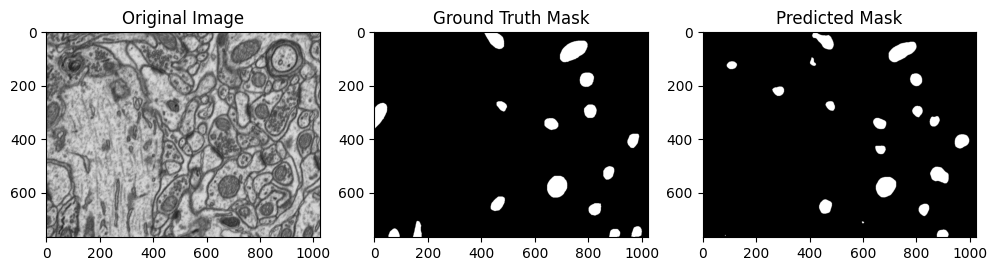

In [24]:
import matplotlib.pyplot as plt

idx = np.random.choice(len(x_test))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(x_test[idx], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(y_test[idx], cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(1, 3, 3)
plt.imshow(predictions_thresholded[idx], cmap='gray')
plt.title('Predicted Mask')

plt.show()


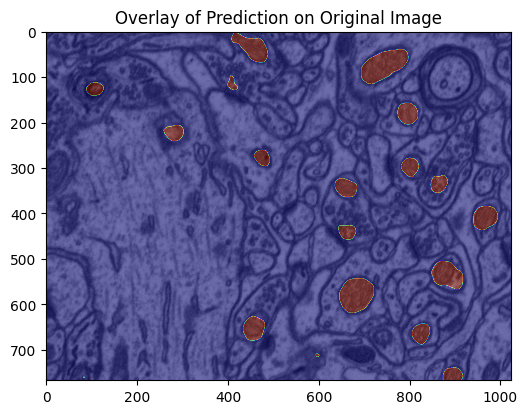

In [25]:
plt.figure(figsize=(6, 6))

plt.imshow(x_test[idx], cmap='gray')
plt.imshow(predictions_thresholded[idx], cmap='jet', alpha=0.5)  # Overlay with some transparency
plt.title('Overlay of Prediction on Original Image')

plt.show()


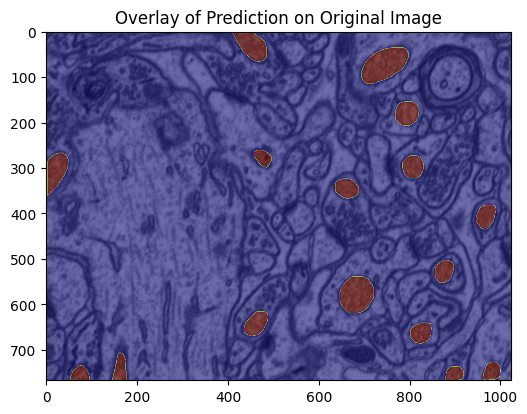

In [41]:
plt.figure(figsize=(6, 6))

plt.imshow(x_test[idx], cmap='gray')
plt.imshow(y_test[idx], cmap='jet', alpha=0.5)  # Overlay with some transparency
plt.title('Overlay of Prediction on Original Image')

plt.show()


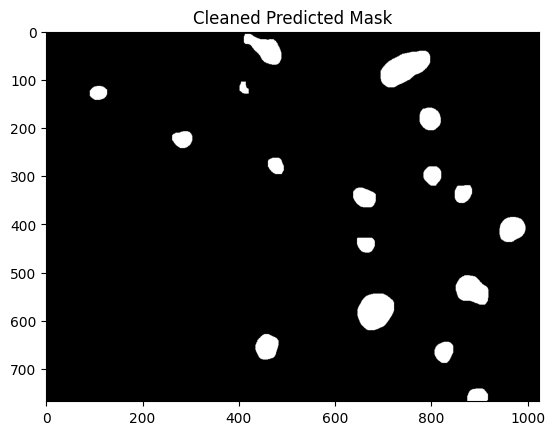

In [44]:
import cv2
import numpy as np

def clean_mask(mask, area_threshold=100, kernel_size=3):
    # Convert mask to binary if it's not already
    _, binary_mask = cv2.threshold(mask, 0.9, 1, cv2.THRESH_BINARY)

    # Morphological opening to remove noise
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

    # Find contours and filter by area
    contours, _ = cv2.findContours(opening.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_mask = np.zeros_like(opening)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > area_threshold:
            cv2.drawContours(filtered_mask, [cnt], -1, (1), thickness=cv2.FILLED)

    return filtered_mask

# Assuming 'predicted_mask' is the raw output from your model for one image
# Apply the cleaning function
cleaned_mask = clean_mask(predictions_thresholded[idx], area_threshold=100, kernel_size=10)

# Now 'cleaned_mask' should have less noise
# You can visualize it using matplotlib
plt.imshow(cleaned_mask, cmap='gray')
plt.title('Cleaned Predicted Mask')
plt.show()
